# Discover and Read EO data - Exercise 1



You have seen how to access the EO data from EODC using the STAC API. Your task now is to find Sentinel-1 Ground Range Detected (GRD) Level-1 SAR data from the EODC. Find data which is:

- closest to your time and location of birth
- closest to your last holiday

### Planned Approach
- Take new collection
- Filter spatially and temporally
- Find available metadata, like ground sampling distance (GSD), polarisations, wavelength of the microwave sensor, resolution, etc.

In [26]:
import pystac_client
import odc.stac
from rasterio.crs import CRS

#### List all collection names and select one

In [27]:
collections = pystac_client.Client.open("https://stac.eodc.eu/api/v1").get_collections()
col = list(collections)
col = [str(c).split('id=')[-1] for c in col if 'sentinel'.upper() in str(c).upper()]
col

# SAR_IMP_1P -> not good
# ERS_ENVISAT_NRB -> not good
# SENTINEL_1_GRD -> maybe good

['SENTINEL2_L2A>',
 'SENTINEL2_GRI_L1C>',
 'SENTINEL1_HPAR>',
 'SENTINEL1_MPLIA>',
 'SENTINEL1_SLC>',
 'SENTINEL1_GRD>',
 'SENTINEL3_SRAL_L2>',
 'SENTINEL2_L1C>',
 'SENTINEL1_SIG0_20M>',
 'SENTINEL2_MFCOVER>',
 'SENTINEL2_L1C_COVERAGE>',
 'SENTINEL1_ALPS_WETSNOW>',
 'Sentinel-2-Greenness-Austria>',
 'SENTINEL1_GRD_COVERAGE>',
 'sentinel2-landsat8-l2f>',
 'BOA_SENTINEL_2>']

In [28]:
collection = pystac_client.Client.open("https://stac.eodc.eu/api/v1").get_collection('SENTINEL1_SIG0_20M')
#collection = pystac_client.Client.open("https://stac.eodc.eu/api/v1").get_collection('SENTINEL1_GRD')
collection

<CollectionClient id=SENTINEL1_SIG0_20M>

#### Define spatial and temporal extent and use client to load the metadata

In [29]:
latmin, latmax = 63.5, 65
lonmin, lonmax = -22.5, -20
bounds = (lonmin, latmin, lonmax, latmax)

#time_range = "2000-09-15/2000-10-15"
time_range = "2022-01-15/2022-02-15"

items = pystac_client.Client.open("https://stac.eodc.eu/api/v1").search(
    bbox=bounds,
    collections=collection,
    datetime=time_range,
    limit=100,
).item_collection()

print(len(items), 'scenes found.')

114 scenes found.


In [30]:
items[0]

<Item id=SIG0_20220214T185941_A016_E039N039T3_EU020M_V1M1R1_S1AIWGRDH>

#### Find necessary metadata, like bands, resolution, coordinate reference system

In [31]:
resolution = items[0].properties['sar:resolution_range']
#crs = items[0].properties['sar:resolution_range']
epsg = CRS.from_epsg(27704)


In [32]:
# Check available assets or bands in the STAC item
available_assets = items[0].assets
available_assets


{'VH': <Asset href=https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_EU020M/E039N039T3/SIG0_20220214T185941__VH_A016_E039N039T3_EU020M_V1M1R1_S1AIWGRDH_TUWIEN.tif>,
 'VV': <Asset href=https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_EU020M/E039N039T3/SIG0_20220214T185941__VV_A016_E039N039T3_EU020M_V1M1R1_S1AIWGRDH_TUWIEN.tif>,
 'thumbnail': <Asset href=https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_EU020M/E039N039T3/SIG0_20220214T185941__VV_A016_E039N039T3_EU020M_V1M1R1_S1AIWGRDH_TUWIEN.tif/thumbnail>}

In [33]:
# Load the data into a Dask array
# lazily combine items
sig0_dc = odc.stac.stac_load(
    items,
    bbox=bounds,
    chunks={'time': 5, 'x': 600, 'y': 600},
    #epsg=epsg,
    crs="EPSG:4326",#epsg,
    resolution=resolution / 111320,
)

sig0_dc

<xarray.Dataset> Size: 9GB
Dimensions:      (latitude: 4175, longitude: 6958, time: 74)
Coordinates:
  * latitude     (latitude) float64 33kB 65.0 65.0 65.0 65.0 ... 63.5 63.5 63.5
  * longitude    (longitude) float64 56kB -22.5 -22.5 -22.5 ... -20.0 -20.0
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 592B 2022-01-16T07:33:26 ... 2022-02-1...
Data variables:
    VH           (time, latitude, longitude) int16 4GB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    VV           (time, latitude, longitude) int16 4GB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>

In [34]:
sig0_dc

<xarray.Dataset> Size: 9GB
Dimensions:      (latitude: 4175, longitude: 6958, time: 74)
Coordinates:
  * latitude     (latitude) float64 33kB 65.0 65.0 65.0 65.0 ... 63.5 63.5 63.5
  * longitude    (longitude) float64 56kB -22.5 -22.5 -22.5 ... -20.0 -20.0
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 592B 2022-01-16T07:33:26 ... 2022-02-1...
Data variables:
    VH           (time, latitude, longitude) int16 4GB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>
    VV           (time, latitude, longitude) int16 4GB dask.array<chunksize=(5, 600, 600), meta=np.ndarray>

#### Define the nodata value and scale factor if `stac_load` didn't include it

In [37]:
# Define the nodata value and scale factor
nodata = items[0].assets['VV'].extra_fields['raster:bands'][0]['nodata']
scale = items[0].assets['VV'].extra_fields['raster:bands'][0]['scale']

sig0 = (sig0_dc.where(sig0_dc != nodata) / scale).VV
#sig0 = sig0_dc.where(sig0_dc != nodata).VV
sig0

<xarray.DataArray 'VV' (time: 74, latitude: 4175, longitude: 6958)> Size: 9GB
dask.array<truediv, shape=(74, 4175, 6958), dtype=float32, chunksize=(5, 600, 600), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 33kB 65.0 65.0 65.0 65.0 ... 63.5 63.5 63.5
  * longitude    (longitude) float64 56kB -22.5 -22.5 -22.5 ... -20.0 -20.0
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 592B 2022-01-16T07:33:26 ... 2022-02-1...

#### Plot the loaded data

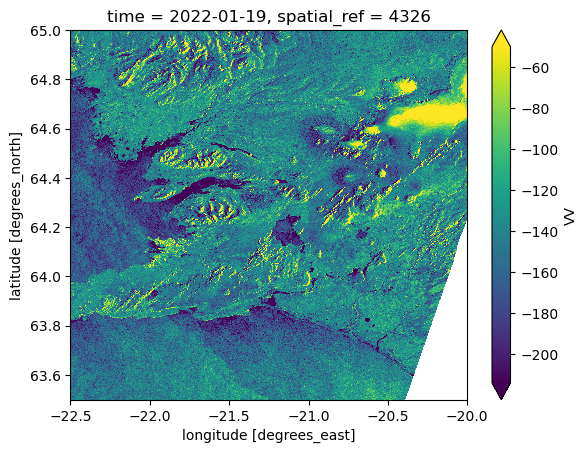

In [36]:
sig0 = sig0.resample(time='1D').max()
sig0.sel(time="2022-01-19", method="nearest").plot.imshow(robust=True)